# Introduction

This notebook constructs a prediction model for the Predict Future Sales competition that is the final project for the Coursera course "[How to Win a Data Science Competition](http://www.coursera.org/learn/competitive-data-science/home/welcome)". The task is to predict monthly sales for various items in different retail outlets of the Russian company 1C.  

I spent several months on this as practice using pandas, so some parts are a bit more complicated than might be expected of a typical short project submission.

There are some other very good notebooks for this competition which are well worth looking at and taught me a lot:
https://www.kaggle.com/dlarionov/feature-engineering-xgboost  
https://www.kaggle.com/gordotron85/future-sales-xgboost-top-3  
https://www.kaggle.com/deepdivelm/feature-engineering-lightgbm-exploring-performance  

This is the top-scoring public notebook at the time of writing (0.84325, place 51 on the public leaderboard), which is mainly because of two novel feature types which work well when combined together. First, there is an item name group feature that groups together items with very similar names that are likely to refer to different versions of the same item (e.g. different editions of the same game or music album). Second, the way the test set was generated was exploited to count how many items sold in the month being predicted were in the same group as the item being predicted (e.g. same category, same name group). This combines well with the item name group feature to detect new items which are part of large multi-format releases that are likely to sell well. Detecting high-selling new items is one of the hardest challenges for the model in this competition (and has to be performed manually to get a really high score, I think).

I hope you find the notebook interesting, and I welcome feedback - suggestions for improvements, advice about parts that are unclear, etc

# Data loading and preprocessing, utility function definition

## Imports and data loading

In [1]:
import gc
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

A few utility functions used throughout the notebook.

In [2]:
def reduce_mem_usage(df, silent=True, allow_categorical=True, float_dtype="float32"):
    """ 
    Iterates through all the columns of a dataframe and downcasts the data type
     to reduce memory usage. Can also factorize categorical columns to integer dtype.
    """
    def _downcast_numeric(series, allow_categorical=allow_categorical):
        """
        Downcast a numeric series into either the smallest possible int dtype or a specified float dtype.
        """
        if pd.api.types.is_sparse(series.dtype) is True:
            return series
        elif pd.api.types.is_numeric_dtype(series.dtype) is False:
            if pd.api.types.is_datetime64_any_dtype(series.dtype):
                return series
            else:
                if allow_categorical:
                    return series
                else:
                    codes, uniques = series.factorize()
                    series = pd.Series(data=codes, index=series.index)
                    series = _downcast_numeric(series)
                    return series
        else:
            series = pd.to_numeric(series, downcast="integer")
        if pd.api.types.is_float_dtype(series.dtype):
            series = series.astype(float_dtype)
        return series

    if silent is False:
        start_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    if df.ndim == 1:
        df = _downcast_numeric(df)
    else:
        for col in df.columns:
            df.loc[:, col] = _downcast_numeric(df.loc[:,col])
    if silent is False:
        end_mem = np.sum(df.memory_usage()) / 1024 ** 2
        print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
        print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))

    return df


def shrink_mem_new_cols(matrix, oldcols=None, allow_categorical=False):
    # Calls reduce_mem_usage on columns which have not yet been optimized
    if oldcols is not None:
        newcols = matrix.columns.difference(oldcols)
    else:
        newcols = matrix.columns
    matrix.loc[:,newcols] = reduce_mem_usage(matrix.loc[:,newcols], allow_categorical=allow_categorical)
    oldcols = matrix.columns  # This is used to track which columns have already been downcast
    return matrix, oldcols


def list_if_not(s, dtype=str):
    # Puts a variable in a list if it is not already a list
    if type(s) not in (dtype, list):
        raise TypeError
    if (s != "") & (type(s) is not list):
        s = [s]
    return s

Load the provided data.

In [3]:
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
shops = pd.read_csv("../input/competitive-data-science-predict-future-sales/shops.csv")
train = pd.read_csv("../input/competitive-data-science-predict-future-sales/sales_train.csv")
test = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")

Convert the date column to the datetime dtype to enable datetime operations.

In [4]:
train["date"] = pd.to_datetime(train["date"], format="%d.%m.%Y")

## Data cleaning

The training dataframe is cleaned with standard steps  


In [5]:
# Merge some duplicate shops
train["shop_id"] = train["shop_id"].replace({0: 57, 1: 58, 11: 10, 40: 39})
# Keep only shops that are in the test set
train = train.loc[train.shop_id.isin(test["shop_id"].unique()), :]
# Drop training items with extreme or negative prices or sales counts
train = train[(train["item_price"] > 0) & (train["item_price"] < 50000)]
train = train[(train["item_cnt_day"] > 0) & (train["item_cnt_day"] < 1000)]

## Preprocessing

The test data seems to be every possible combination (the cartesian product) of shops and items that registered a sale in the test month, with the target as the total month's sales made for each of these shop-item combinations. Here a training matrix is made that replicates this structure for every month in the training data period. The test items are concatenated to the end of the training data so that features can be generated for the test period.

In [6]:
def create_testlike_train(sales_train, test=None):
    indexlist = []
    for i in sales_train.date_block_num.unique():
        x = itertools.product(
            [i],
            sales_train.loc[sales_train.date_block_num == i].shop_id.unique(),
            sales_train.loc[sales_train.date_block_num == i].item_id.unique(),
        )
        indexlist.append(np.array(list(x)))
    df = pd.DataFrame(
        data=np.concatenate(indexlist, axis=0),
        columns=["date_block_num", "shop_id", "item_id"],
    )

    # Add revenue column to sales_train
    sales_train["item_revenue_day"] = sales_train["item_price"] * sales_train["item_cnt_day"]
    # Aggregate item_id / shop_id item_cnts and revenue at the month level
    sales_train_grouped = sales_train.groupby(["date_block_num", "shop_id", "item_id"]).agg(
        item_cnt_month=pd.NamedAgg(column="item_cnt_day", aggfunc="sum"),
        item_revenue_month=pd.NamedAgg(column="item_revenue_day", aggfunc="sum"),
    )

    # Merge the grouped data with the index
    df = df.merge(
        sales_train_grouped, how="left", on=["date_block_num", "shop_id", "item_id"],
    )

    if test is not None:
        test["date_block_num"] = 34
        test["date_block_num"] = test["date_block_num"].astype(np.int8)
        test["shop_id"] = test.shop_id.astype(np.int8)
        test["item_id"] = test.item_id.astype(np.int16)
        test = test.drop(columns="ID")

        df = pd.concat([df, test[["date_block_num", "shop_id", "item_id"]]])

    # Fill empty item_cnt entries with 0
    df.item_cnt_month = df.item_cnt_month.fillna(0)
    df.item_revenue_month = df.item_revenue_month.fillna(0)

    return df

In [7]:
matrix = create_testlike_train(train, test)
del(test)

The function reduce_mem_usage downcasts datatypes to reduce memory usage, which is necessary to prevent memory overflow errors in the Kaggle notebook.

In [8]:
matrix = reduce_mem_usage(matrix, silent=False)
oldcols = matrix.columns

Memory usage of dataframe is 405.44 MB
Memory usage after optimization is: 152.04 MB
Decreased by 62.5%


## Feature engineering  
In this section predictor feature columns are generated and added to the matrix

# Item name groups with fuzzywuzzy

Items in the items table are ordered alphabetically according to the item_name field, so that similar items are generally listed next to each other. For example, the first two items in the table below are the same game "Fuse" for two different consoles, followed by two different licensing options for the same internet security program. This ordering can be used to help group related items together.  

In [9]:
items.query("item_id>3564").head(5)

,item_name,item_id,item_category_id
3565,"Fuse [PS3, английская версия]",3565,19
3566,"Fuse [Xbox 360, английская версия]",3566,23
3567,G Data Internet Security 2013 (1ПК / 1 год) (G...,3567,76
3568,G Data Internet Security 2013 (3ПК / 1 год) (G...,3568,76
3569,GABIN The Best Of Gabin 2CD,3569,55


The following cell groups similar items together by sequentially looping through items, measuring the similarity of the names of ajacent items using the string matching package fuzzywuzzy (https://github.com/seatgeek/fuzzywuzzy), and assigning items to the same group if their match value is above a threshold.

In [10]:
import re

from fuzzywuzzy import fuzz


def add_item_name_groups(matrix, train, items, sim_thresh, feature_name="item_name_group"):
    def partialmatchgroups(items, sim_thresh=sim_thresh):
        def strip_brackets(string):
            string = re.sub(r"\(.*?\)", "", string)
            string = re.sub(r"\[.*?\]", "", string)
            return string

        items = items.copy()
        items["nc"] = items.item_name.apply(strip_brackets)
        items["ncnext"] = np.concatenate((items["nc"].to_numpy()[1:], np.array([""])))

        def partialcompare(s):
            return fuzz.partial_ratio(s["nc"], s["ncnext"])

        items["partialmatch"] = items.apply(partialcompare, axis=1)
        # Assign groups
        grp = 0
        for i in range(items.shape[0]):
            items.loc[i, "partialmatchgroup"] = grp
            if items.loc[i, "partialmatch"] < sim_thresh:
                grp += 1
        items = items.drop(columns=["nc", "ncnext", "partialmatch"])
        return items

    items = partialmatchgroups(items)
    items = items.rename(columns={"partialmatchgroup": feature_name})
    items = items.drop(columns="partialmatchgroup", errors="ignore")

    items[feature_name] = items[feature_name].apply(str)
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left")
    train = train.merge(items[["item_id", feature_name]], on="item_id", how="left")
    return matrix, train


matrix, train = add_item_name_groups(matrix, train, items, 65)

# Music artist / first word of item name  

This function assigns music items into groups according to the artist name, which is extracted from the item name with regular expressions according to 3 common patterns used to indicate the artist name (all uppercase, separated from the release title by a doublespace, or separated by dot-space (. ).  
For non-music categories, the items are grouped according to the first word in the item name instead.

In [11]:
from nltk.corpus import stopwords


def add_first_word_features(matrix, items=items, feature_name="artist_name_or_first_word"):
    # This extracts artist names for music categories and adds them as a feature.
    def extract_artist(st):
        st = st.strip()
        if st.startswith("V/A"):
            artist = "V/A"
        elif st.startswith("СБ"):
            artist = "СБ"
        else:
            # Retrieves artist names using the double space or all uppercase pattern
            mus_artist_dubspace = re.compile(r".{2,}?(?=\s{2,})")
            match_dubspace = mus_artist_dubspace.match(st)
            mus_artist_capsonly = re.compile(r"^([^a-zа-я]+\s)+")
            match_capsonly = mus_artist_capsonly.match(st)
            candidates = [match_dubspace, match_capsonly]
            candidates = [m[0] for m in candidates if m is not None]
            # Sometimes one of the patterns catches some extra words so choose the shortest one
            if len(candidates):
                artist = min(candidates, key=len)
            else:
                # If neither of the previous patterns found something, use the dot-space pattern
                mus_artist_dotspace = re.compile(r".{2,}?(?=\.\s)")
                match = mus_artist_dotspace.match(st)
                if match:
                    artist = match[0]
                else:
                    artist = ""
        artist = artist.upper()
        artist = re.sub(r"[^A-ZА-Я ]||\bTHE\b", "", artist)
        artist = re.sub(r"\s{2,}", " ", artist)
        artist = artist.strip()
        return artist

    items = items.copy()
    all_stopwords = stopwords.words("russian")
    all_stopwords = all_stopwords + stopwords.words("english")

    def first_word(string):
        # This cleans the string of special characters, excess spaces and stopwords then extracts the first word
        string = re.sub(r"[^\w\s]", "", string)
        string = re.sub(r"\s{2,}", " ", string)
        tokens = string.lower().split()
        tokens = [t for t in tokens if t not in all_stopwords]
        token = tokens[0] if len(tokens) > 0 else ""
        return token

    music_categories = [55, 56, 57, 58, 59, 60]
    items.loc[items.item_category_id.isin(music_categories), feature_name] = items.loc[
        items.item_category_id.isin(music_categories), "item_name"
    ].apply(extract_artist)
    items.loc[items[feature_name] == "", feature_name] = "other music"
    items.loc[~items.item_category_id.isin(music_categories), feature_name] = items.loc[
        ~items.item_category_id.isin(music_categories), "item_name"
    ].apply(first_word)
    items.loc[items[feature_name] == "", feature_name] = "other non-music"
    items[feature_name] = items[feature_name].factorize()[0]
    matrix = matrix.merge(items[["item_id", feature_name]], on="item_id", how="left",)
    return matrix


matrix = add_first_word_features(
    matrix, items=items, feature_name="artist_name_or_first_word"
)

# Item name length as a feature
The name of the item_name field is surprisingly predictive, presumably because similar items often have similar length names. This is recorded both from the raw item name and the name cleaned of special characters and bracketed terms, which often contain information about release formats that obscure similarities between items.

In [12]:
import re
def clean_item_name(string):
    # Removes bracketed terms, special characters and extra whitespace
    string = re.sub(r"\[.*?\]", "", string)
    string = re.sub(r"\(.*?\)", "", string)
    string = re.sub(r"[^A-ZА-Яa-zа-я0-9 ]", "", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = string.lower()
    return string

items["item_name_cleaned_length"] = items["item_name"].apply(clean_item_name).apply(len)
items["item_name_length"] = items["item_name"].apply(len)
matrix = matrix.merge(items[['item_id', 'item_name_length', 'item_name_cleaned_length']], how='left', on='item_id')
items = items.drop(columns=['item_name_length', 'item_name_cleaned_length'])

In [13]:
print("Created name features")
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

Created name features


# Time features
Day and month-resolution time features are created from the training dataframe, e.g. number of days since the first and last sale of each item.

The time since the first sale of each items is also used to create a mean sales-per-day feature ("item_cnt_day_avg"), which is potentially useful to correct sales counts for items which are less than a month old and therefore were not available to buy for the entire preceding month.  

In [14]:
def add_time_features(m, train, correct_item_cnt_day=False):
    from pandas.tseries.offsets import Day, MonthBegin, MonthEnd

    def item_shop_age_months(m):
        m["item_age"] = m.groupby("item_id")["date_block_num"].transform(
            lambda x: x - x.min()
        )
        # Sales tend to plateau after 12 months
        m["new_item"] = m["item_age"] == 0
        m["new_item"] = m["new_item"].astype("int8")
        m["shop_age"] = (
            m.groupby("shop_id")["date_block_num"]
            .transform(lambda x: x - x.min())
            .astype("int8")
        )
        return m

    # Add dummy values for the test month so that features are created correctly
    dummies = m.loc[m.date_block_num == 34, ["date_block_num", "shop_id", "item_id"]]
    dummies = dummies.assign(
        date=pd.to_datetime("2015-11-30"), item_price=1, item_cnt_day=0, item_revenue_day=0,
    )
    train = pd.concat([train, dummies])
    del dummies

    month_last_day = train.groupby("date_block_num").date.max().rename("month_last_day")
    month_last_day[~month_last_day.dt.is_month_end] = (
        month_last_day[~month_last_day.dt.is_month_end] + MonthEnd()
    )
    month_first_day = train.groupby("date_block_num").date.min().rename("month_first_day")
    month_first_day[~month_first_day.dt.is_month_start] = (
        month_first_day[~month_first_day.dt.is_month_start] - MonthBegin()
    )
    month_length = (month_last_day - month_first_day + Day()).rename("month_length")
    first_shop_date = train.groupby("shop_id").date.min().rename("first_shop_date")
    first_item_date = train.groupby("item_id").date.min().rename("first_item_date")
    first_shop_item_date = (
        train.groupby(["shop_id", "item_id"]).date.min().rename("first_shop_item_date")
    )
    first_item_name_group_date = (
        train.groupby("item_name_group").date.min().rename("first_name_group_date")
    )

    m = m.merge(month_first_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_last_day, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(month_length, left_on="date_block_num", right_index=True, how="left")
    m = m.merge(first_shop_date, left_on="shop_id", right_index=True, how="left")
    m = m.merge(first_item_date, left_on="item_id", right_index=True, how="left")
    m = m.merge(
        first_shop_item_date, left_on=["shop_id", "item_id"], right_index=True, how="left"
    )
    m = m.merge(
        first_item_name_group_date, left_on="item_name_group", right_index=True, how="left"
    )

    # Calculate how long the item was sold for in each month and use this to calculate average sales per day
    m["shop_open_days"] = m["month_last_day"] - m["first_shop_date"] + Day()
    m["item_first_sale_days"] = m["month_last_day"] - m["first_item_date"] + Day()
    m["item_in_shop_days"] = (
        m[["shop_open_days", "item_first_sale_days", "month_length"]].min(axis=1).dt.days
    )
    m = m.drop(columns="item_first_sale_days")
    m["item_cnt_day_avg"] = m["item_cnt_month"] / m["item_in_shop_days"]
    m["month_length"] = m["month_length"].dt.days

    # Calculate the time differences from the beginning of the month so they can be used as features without lagging
    m["shop_open_days"] = m["month_first_day"] - m["first_shop_date"]
    m["first_item_sale_days"] = m["month_first_day"] - m["first_item_date"]
    m["first_shop_item_sale_days"] = m["month_first_day"] - m["first_shop_item_date"]
    m["first_name_group_sale_days"] = m["month_first_day"] - m["first_name_group_date"]
    m["shop_open_days"] = m["shop_open_days"].dt.days.fillna(0).clip(lower=0)
    m["first_item_sale_days"] = (
        m["first_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_shop_item_sale_days"] = (
        m["first_shop_item_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )
    m["first_name_group_sale_days"] = (
        m["first_name_group_sale_days"].dt.days.fillna(0).clip(lower=0).replace(0, 9999)
    )

    # Add days since last sale
    def last_sale_days(matrix):
        last_shop_item_dates = []
        for dbn in range(1, 35):
            lsid_temp = (
                train.query(f"date_block_num<{dbn}")
                .groupby(["shop_id", "item_id"])
                .date.max()
                .rename("last_shop_item_sale_date")
                .reset_index()
            )
            lsid_temp["date_block_num"] = dbn
            last_shop_item_dates.append(lsid_temp)

        last_shop_item_dates = pd.concat(last_shop_item_dates)
        matrix = matrix.merge(
            last_shop_item_dates, on=["date_block_num", "shop_id", "item_id"], how="left"
        )

        def days_since_last_feat(m, feat_name, date_feat_name, missingval):
            m[feat_name] = (m["month_first_day"] - m[date_feat_name]).dt.days
            m.loc[m[feat_name] > 2000, feat_name] = missingval
            m.loc[m[feat_name].isna(), feat_name] = missingval
            return m

        matrix = days_since_last_feat(
            matrix, "last_shop_item_sale_days", "last_shop_item_sale_date", 9999
        )

        matrix = matrix.drop(columns=["last_shop_item_sale_date"])
        return matrix

    m = last_sale_days(m)
    # Month id feature
    m["month"] = m["month_first_day"].dt.month

    m = m.drop(
        columns=[
            "first_day",
            "month_first_day",
            "month_last_day",
            "first_shop_date",
            "first_item_date",
            "first_name_group_date",
            "item_in_shop_days",
            "first_shop_item_date",
            "month_length",
        ],
        errors="ignore",
    )

    m = item_shop_age_months(m)

    if correct_item_cnt_day == True:
        m["item_cnt_month_original"] = m["item_cnt_month"]
        m["item_cnt_month"] = m["item_cnt_day_avg"] * m["month_length"]

    return m

In [15]:
matrix = add_time_features(matrix, train, False)
print("Time features created")

Time features created


# Price features  

The price of the item in the last month in which it was sold, and its price relative to other items in the same category.

In [16]:
def add_price_features(matrix, train):
    # Get mean prices per month from train dataframe
    price_features = train.groupby(["date_block_num", "item_id"]).item_price.mean()
    price_features = pd.DataFrame(price_features)
    price_features = price_features.reset_index()
    # Calculate normalized differenced from mean category price per month
    price_features = price_features.merge(
        items[["item_id", "item_category_id"]], how="left", on="item_id"
    )
    price_features["norm_diff_cat_price"] = price_features.groupby(
        ["date_block_num", "item_category_id"]
    )["item_price"].transform(lambda x: (x - x.mean()) / x.mean())
    # Retain only the necessary features
    price_features = price_features[
        [
            "date_block_num",
            "item_id",
            "item_price",
            "norm_diff_cat_price",
        ]
    ]

    features = [
        "item_price",
        "norm_diff_cat_price",
    ]
    newnames = ["last_" + f for f in features]
    aggs = {f: "last" for f in features}
    renames = {f: "last_" + f for f in features}
    features = []
    for dbn in range(1, 35):
        f_temp = (
            price_features.query(f"date_block_num<{dbn}")
            .groupby("item_id")
            .agg(aggs)
            .rename(columns=renames)
        )
        f_temp["date_block_num"] = dbn
        features.append(f_temp)
    features = pd.concat(features).reset_index()
    matrix = matrix.merge(features, on=["date_block_num", "item_id"], how="left")
    return matrix

In [17]:
matrix = add_price_features(matrix, train)
del(train)

# Item category features  
In addition to the item categories provided with the data, I also manually defined two additional category groupings - supercategory (e.g. "games", "music") and platform (e.g. "PS4", "mp3").

In [18]:
matrix = matrix.merge(items[['item_id', 'item_category_id']], on='item_id', how='left')

platform_map = {
    0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 8, 10: 1, 11: 2,
    12: 3, 13: 4, 14: 5, 15: 6, 16: 7, 17: 8, 18: 1, 19: 2, 20: 3, 21: 4, 22: 5,
    23: 6, 24: 7, 25: 8, 26: 9, 27: 10, 28: 0, 29: 0, 30: 0, 31: 0, 32: 8, 33: 11,
    34: 11, 35: 3, 36: 0, 37: 12, 38: 12, 39: 12, 40: 13, 41: 13, 42: 14, 43: 15,
    44: 15, 45: 15, 46: 14, 47: 14, 48: 14, 49: 14, 50: 14, 51: 14, 52: 14, 53: 14,
    54: 8, 55: 16, 56: 16, 57: 17, 58: 18, 59: 13, 60: 16, 61: 8, 62: 8, 63: 8, 64: 8,
    65: 8, 66: 8, 67: 8, 68: 8, 69: 8, 70: 8, 71: 8, 72: 8, 73: 0, 74: 10, 75: 0,
    76: 0, 77: 0, 78: 0, 79: 8, 80: 8, 81: 8, 82: 8, 83: 8,
}
matrix['platform_id'] = matrix['item_category_id'].map(platform_map)

supercat_map = {
    0: 0, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 2, 9: 2, 10: 1, 11: 1, 12: 1,
    13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 3, 19: 3, 20: 3, 21: 3, 22: 3, 23: 3,
    24: 3, 25: 0, 26: 2, 27: 3, 28: 3, 29: 3, 30: 3, 31: 3, 32: 2, 33: 2, 34: 2,
    35: 2, 36: 2, 37: 4, 38: 4, 39: 4, 40: 4, 41: 4, 42: 5, 43: 5, 44: 5, 45: 5,
    46: 5, 47: 5, 48: 5, 49: 5, 50: 5, 51: 5, 52: 5, 53: 5, 54: 5, 55: 6, 56: 6,
    57: 6, 58: 6, 59: 6, 60: 6, 61: 0, 62: 0, 63: 0, 64: 0, 65: 0, 66: 0, 67: 0,
    68: 0, 69: 0, 70: 0, 71: 0, 72: 0, 73: 7, 74: 7, 75: 7, 76: 7, 77: 7, 78: 7,
    79: 2, 80: 2, 81: 0, 82: 0, 83: 0
}
matrix['supercategory_id'] = matrix['item_category_id'].map(supercat_map)

# Shop city
(from https://www.kaggle.com/dlarionov/feature-engineering-xgboost)

In [19]:
def add_city_codes(matrix, shops):
    shops.loc[
        shops.shop_name == 'Сергиев Посад ТЦ "7Я"', "shop_name"
    ] = 'СергиевПосад ТЦ "7Я"'
    shops["city"] = shops["shop_name"].str.split(" ").map(lambda x: x[0])
    shops.loc[shops.city == "!Якутск", "city"] = "Якутск"
    shops["city_code"] = shops["city"].factorize()[0]
    shop_labels = shops[["shop_id", "city_code"]]
    matrix = matrix.merge(shop_labels, on='shop_id', how='left')
    return matrix

matrix = add_city_codes(matrix, shops)
del(shops)

# Shop and item category clustering

Shops and item categories are grouped into clusters according to their sales profiles. 
The following function performs and plots the results of a principle component analysis decomposition and clustering of the shops and item categories.

The proportion of explained variance between items explained by each of the PCA dimensions is plotted, and the individual items are plotted according to their scores on the PCA dimensions and coloured according to their cluster assignment.

The silhouette score (a metric of clustering quality) for different values of the cluster number parameter is also plotted. These plots were used to decide the number of clusters.

For both shops and item categories, over 80% of differences occur on a single dimension, indicating that differences are mainly in magnitude rather than proportion. The item component score plots show that the clustering is mainly into a large cluster containing the large majority of items, and a few clusters containing outlier items.

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score


def cluster_feature(matrix, target_feature, clust_feature, level_feature, n_components=4, n_clusters=5, aggfunc="mean", exclude=None):
    start_month = 20
    end_month = 32
    pt = matrix.query(f"date_block_num>{start_month} & date_block_num<={end_month}")
    if exclude is not None:
        pt = matrix[~matrix[clust_feature].isin(exclude)]
    pt = pt.pivot_table(values=target_feature, columns=clust_feature, index=level_feature, fill_value=0, aggfunc=aggfunc)
    pt = pt.transpose()
    pca = PCA(n_components=10)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    # Plot PCA explained variance
    sns.set_theme()
    features = list(range(pca.n_components_))
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
#     ax.bar(features, pca.explained_variance_ratio_, color="black")
    sns.barplot(x=features, y=pca.explained_variance_ratio_, ax=ax)
    plt.title("Variance by PCA components")
    plt.xlabel("component")
    plt.ylabel("explained variance")
    plt.xticks(features)

    scorelist = []
    nrange = range(2, 10)
    for n in nrange:
        clusterer = AgglomerativeClustering(n_clusters=n)
        labels = clusterer.fit_predict(components)
        silscore = silhouette_score(pt, labels)
        scorelist.append(silscore)
    ax = fig.add_subplot(122)
    sns.lineplot(x=nrange, y=scorelist, ax=ax)
    plt.title("Clustering quality by number of clusters")
    plt.xlabel("n clusters")
    plt.ylabel("silhouette score")

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(pt)
    components = pd.DataFrame(components)
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, linkage="average")
    labels = clusterer.fit_predict(components)
    x = components[0]
    y = components[1]
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(111)
    sns.scatterplot(x=x, y=y, hue=labels, palette=sns.color_palette("hls", n_clusters), ax=ax)
    plt.title("Items by cluster")
    plt.xlabel("component 1 score")
    plt.ylabel("component 2 score")
    for i, txt in enumerate(pt.index.to_list()):
        ax.annotate(str(txt), (x[i], y[i]))
    groups = {}
    for i, s in enumerate(pt.index):
        groups[s] = labels[i]
    return groups

Item categories are clustered according to their mean sales in each month of the year. The principle component plot shows that 3 categories are outliers in this respect.

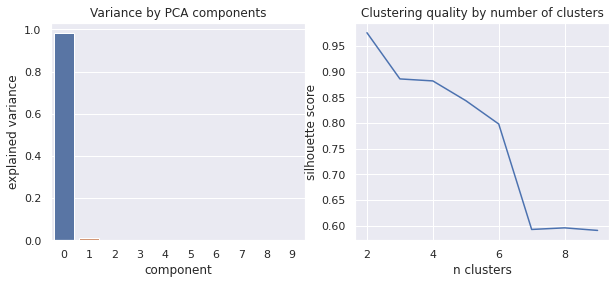

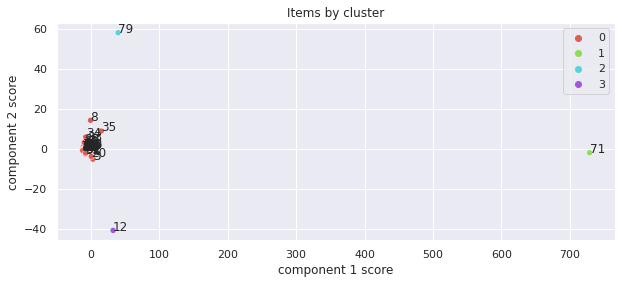

In [21]:
category_group_dict = cluster_feature(matrix, 'item_cnt_month', 'item_category_id', 'date_block_num', n_components=2, n_clusters=4, aggfunc="mean", exclude =[])
matrix['category_cluster'] = matrix['item_category_id'].map(category_group_dict)

Shops are clustered by their summed sales of each item category. The principle component plots show that shops mainly differ in the magnitude of their sales, with shop 31 being an outlier due to the volume of its sales. Shops 12 and 55 are outliers on an orthogonal dimension because they sell different (online only) items.

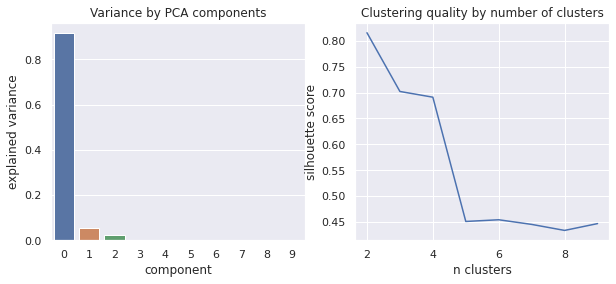

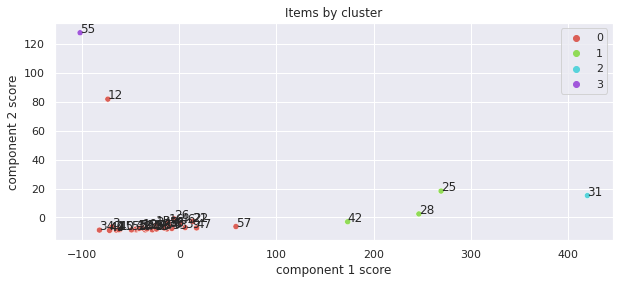

In [22]:
shop_group_dict = cluster_feature(matrix, 'item_cnt_month', 'shop_id', 'item_category_id', n_components=4, n_clusters=4, aggfunc="mean", exclude=[36])
shop_group_dict[36] = shop_group_dict[37]  # Shop36 added separately because it only has one month of data
matrix['shop_cluster'] = matrix['shop_id'].map(shop_group_dict)

In [23]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)  # Use this function periodically to downcast dtypes to save memory

# Number of unique item features

These features count the number of unique items sharing the same value of a grouping feature or set of features as the current item in the current month, e.g. number of new items in the same category.  

This could considered to be a kind of data leakage feature, as the set of items in each month (and therefore the test set) is determined by whether each item recorded a sale or not in the month being predicted, which isn't known in advance.

In [24]:
def uniques(matrix, groupers, name, limitation=None):
    if limitation is not None:
        s = (
            matrix.query(limitation)
            .groupby(groupers)
            .item_id.nunique()
            .rename(name)
            .reset_index()
        )
    else:
        s = matrix.groupby(groupers).item_id.nunique().rename(name).reset_index()
    matrix = matrix.merge(s, on=groupers, how="left")
    matrix[name] = matrix[name].fillna(0)
    return matrix


matrix = uniques(matrix, ["date_block_num"], "unique_items_month")

matrix = uniques(matrix, ["date_block_num", "item_name_group"], "name_group_unique_month")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_name_group"],
    "name_group_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "item_name_group"],
    "name_group_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(
    matrix, ["date_block_num", "artist_name_or_first_word"], "first_word_unique_month"
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_cat_unique_month",
)
matrix = uniques(
    matrix,
    ["date_block_num", "artist_name_or_first_word"],
    "first_word_new_unique_month",
    limitation="new_item==True",
)
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id", "artist_name_or_first_word"],
    "first_word_new_cat_unique_month",
    limitation="new_item==True",
)

matrix = uniques(matrix, ["date_block_num", "item_category_id"], "unique_items_cat")
matrix = uniques(
    matrix,
    ["date_block_num", "item_category_id"],
    "new_items_cat",
    limitation="new_item==True",
)
matrix = uniques(matrix, ["date_block_num"], "new_items_month", limitation="new_item==True")

matrix["cat_items_proportion"] = matrix["unique_items_cat"] / matrix["unique_items_month"]
matrix["name_group_new_proportion_month"] = (
    matrix["name_group_new_unique_month"] / matrix["name_group_unique_month"]
)

matrix = matrix.drop(columns=["unique_items_month", "name_group_unique_month"])

In [25]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Percentage change in an aggregate feature  
This uses the pandas pct_change method to calculate the proportional change in mean sales count for a specific grouping for a specific time interval, e.g. increase / decrease in mean sales of an item between the last 2 months.

In [26]:
def add_pct_change(
    matrix,
    group_feats,
    target="item_cnt_month",
    aggfunc="mean",
    periods=1,
    lag=1,
    clip_value=None,
):
    periods = list_if_not(periods, int)
    group_feats = list_if_not(group_feats)
    group_feats_full = ["date_block_num"] + group_feats
    dat = matrix.pivot_table(
        index=group_feats + ["date_block_num"],
        values=target,
        aggfunc=aggfunc,
        fill_value=0,
        dropna=False,
    ).astype("float32")
    for g in group_feats:
        firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
        dat = dat.merge(firsts, left_on=g, right_index=True, how="left")
        dat.loc[dat.index.get_level_values("date_block_num") < dat["firsts"], target] = float(
            "nan"
        )
        del dat["firsts"]
    for period in periods:
        feat_name = "_".join(
            group_feats + [target] + [aggfunc] + ["delta"] + [str(period)] + [f"lag_{lag}"]
        )
        print(f"Adding feature {feat_name}")
        dat = (
            dat.groupby(group_feats)[target]
            .transform(lambda x: x.pct_change(periods=period, fill_method="pad"))
            .rename(feat_name)
        )
        if clip_value is not None:
            dat = dat.clip(lower=-clip_value, upper=clip_value)
    dat = dat.reset_index()
    dat["date_block_num"] += lag
    matrix = matrix.merge(dat, on=["date_block_num"] + group_feats, how="left")
    matrix[feat_name] = reduce_mem_usage(matrix[feat_name])
    return matrix

In [27]:
matrix = add_pct_change(matrix, ["item_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", clip_value=3)
matrix = add_pct_change(matrix, ["item_name_group"], "item_cnt_month", clip_value=3)
# Delta 1 feature lagged by 12 months, intended to capture seasonal trends
matrix = add_pct_change(matrix, ["item_category_id"], "item_cnt_month", lag=12, clip_value=3,)
gc.collect()

Adding feature item_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_1
Adding feature item_name_group_item_cnt_month_mean_delta_1_lag_1
Adding feature item_category_id_item_cnt_month_mean_delta_1_lag_12


5

In [28]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Windowed aggregates

Features aggregated over a specific window to reduce noise. Available windows are expanding (i.e. all preceding timepoints), rolling (i.e. fixed number of equally weighted timepoints) and exponentially weighted mean.  


A note about feature names: these are set automatically according to the pattern < grouping features > - < aggregated features > - < monthly aggregation function > - < window type > , where < window type > is either "rolling - < window aggregation function > - win - < window length in months >" for square rolling windows, "expanding - < window aggregation function >" for expanding windows, and "ewm_hl - < decay rate in terms of half-life > for exponential weighted means, all connected by underscores.

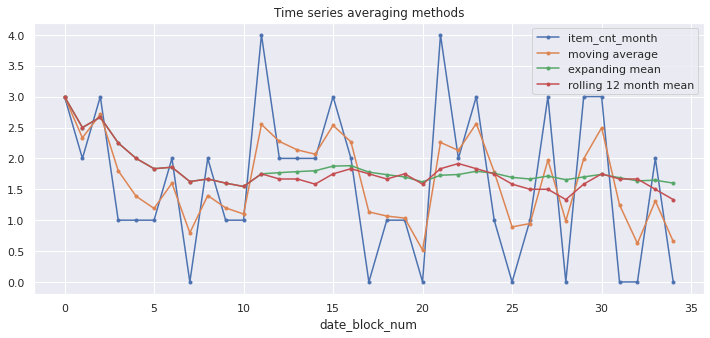

In [29]:
shop_id = 16
item_id = 482
im = matrix.query(f"shop_id=={shop_id} & item_id=={item_id}")[['date_block_num', 'item_cnt_month']]
im['moving average'] = im['item_cnt_month'].ewm(halflife=1).mean()
im['expanding mean'] = im['item_cnt_month'].expanding().mean()
im['rolling 12 month mean'] = im['item_cnt_month'].rolling(window=12, min_periods=1).mean()
im = im.set_index('date_block_num')
ax = im.plot(figsize=(12,5), marker='.', title='Time series averaging methods')

In [30]:
def add_rolling_stats(
    matrix,
    features,
    window=12,
    kind="rolling",
    argfeat="item_cnt_month",
    aggfunc="mean",
    rolling_aggfunc="mean",
    dtype="float16",
    reshape_source=True,
    lag_offset=0,
):
    def rolling_stat(
        matrix,
        source,
        feats,
        feat_name,
        window=12,
        argfeat="item_cnt_month",
        aggfunc="mean",
        dtype=dtype,
        lag_offset=0,
    ):
        # Calculate a statistic on a windowed section of a source table,  grouping on specific features
        store = []
        for i in range(2 + lag_offset, 35 + lag_offset):
            if len(feats) > 0:
                mes = (
                    source[source.date_block_num.isin(range(max([i - window, 0]), i))]
                    .groupby(feats)[argfeat]
                    .agg(aggfunc)
                    .astype(dtype)
                    .rename(feat_name)
                    .reset_index()
                )
            else:
                mes = {}
                mes[feat_name] = (
                    source.loc[
                        source.date_block_num.isin(range(max([i - window, 0]), i)), argfeat
                    ]
                    .agg(aggfunc)
                    .astype(dtype)
                )
                mes = pd.DataFrame(data=mes, index=[i])
            mes["date_block_num"] = i - lag_offset
            store.append(mes)
        store = pd.concat(store)
        matrix = matrix.merge(store, on=feats + ["date_block_num"], how="left")
        return matrix

    """ An issue when using windowed functions is that missing values from months when items recorded no sales are skipped rather than being correctly
    treated as zeroes. Creating a pivot_table fills in the zeros."""
    if (reshape_source == True) or (kind == "ewm"):
        source = matrix.pivot_table(
            index=features + ["date_block_num"],
            values=argfeat,
            aggfunc=aggfunc,
            fill_value=0,
            dropna=False,
        ).astype(dtype)
        for g in features:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            source = source.merge(firsts, left_on=g, right_index=True, how="left")
            # Set values before the items first appearance to nan so they are ignored rather than being treated as zero sales.
            source.loc[
                source.index.get_level_values("date_block_num") < source["firsts"], argfeat
            ] = float("nan")
            del source["firsts"]
        source = source.reset_index()
    else:
        source = matrix

    if kind == "rolling":
        feat_name = (
            f"{'_'.join(features)}_{argfeat}_{aggfunc}_rolling_{rolling_aggfunc}_win_{window}"
        )
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=window,
            argfeat=argfeat,
            aggfunc=rolling_aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "expanding":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_expanding_{rolling_aggfunc}"
        print(f'Creating feature "{feat_name}"')
        return rolling_stat(
            matrix,
            source,
            features,
            feat_name,
            window=100,
            argfeat=argfeat,
            aggfunc=aggfunc,
            dtype=dtype,
            lag_offset=lag_offset,
        )
    elif kind == "ewm":
        feat_name = f"{'_'.join(features)}_{argfeat}_{aggfunc}_ewm_hl_{window}"
        print(f'Creating feature "{feat_name}"')
        source[feat_name] = (
            source.groupby(features)[argfeat]
            .ewm(halflife=window, min_periods=1)
            .agg(rolling_aggfunc)
            .to_numpy(dtype=dtype)
        )
        del source[argfeat]
        #         source = source.reset_index()
        source["date_block_num"] += 1 - lag_offset
        return matrix.merge(source, on=["date_block_num"] + features, how="left")

Create rolling mean features. The combinations of grouping features and window types here were selected by generating a large number of features and then pruning them with the scikit-learn RFECV function.

In [31]:
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "artist_name_or_first_word", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(matrix, ["shop_id", "category_cluster"], window=12)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_category_id", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["shop_id", "item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_category_id", "new_item"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_category_id", "new_item"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["shop_id"], window=12)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["shop_id", "item_id"], window=12)
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_name_group", "item_category_id", "new_item"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "item_name_group", "new_item"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(
    matrix, ["shop_id", "supercategory_id", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats(matrix, ["shop_cluster", "item_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix,
    ["shop_cluster", "item_category_id", "item_age"],
    kind="expanding",
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["shop_cluster", "item_name_group", "new_item"], window=12, reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["category_cluster", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(
    matrix, ["category_cluster", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(matrix, ["item_id"], window=12)

matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], window=12)
matrix = add_rolling_stats(matrix, ["artist_name_or_first_word"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix, ["artist_name_or_first_word", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(
    matrix,
    ["artist_name_or_first_word", "item_category_id", "item_age"],
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix, ["artist_name_or_first_word", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["item_category_id", "item_age"], kind="expanding", reshape_source=False
)
matrix = add_rolling_stats(matrix, ["item_category_id"], window=12)
matrix = add_rolling_stats(matrix, ["item_category_id"], kind="ewm", window=1)
matrix = add_rolling_stats(
    matrix, ["item_category_id", "new_item"], kind="expanding", reshape_source=False
)

matrix = add_rolling_stats(
    matrix, ["item_name_group", "item_age"], window=12, reshape_source=False
)
matrix = add_rolling_stats(matrix, ["item_name_group"], kind="ewm", window=1)
matrix = add_rolling_stats(matrix, ["item_name_group"], window=12)

matrix = add_rolling_stats(matrix, ["platform_id"], window=12)
matrix = add_rolling_stats(matrix, ["platform_id"], kind="ewm", window=1)

Creating feature "shop_id_artist_name_or_first_word_item_category_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_artist_name_or_first_word_item_category_id_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_artist_name_or_first_word_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_category_cluster_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_age_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_item_age_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_category_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "shop_id_item_category_id_new_item_item_cnt_month_mean_expanding_mean"
Creating feature "shop_id_item_category_id_new_item_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_cnt_month_mean_rolling_mean_win_12"
Creating feature "shop_id_item_id_item_cnt_month_mean_ewm_hl_1"
Creating feature "sh

In [32]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

The following code block calculates windowed mean sales features with day resolution accuracy

In [33]:
# Summed sales & accurate windowed mean sales per day features
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_id"],
    aggfunc="sum",
    rolling_aggfunc="sum",
    kind="rolling",
    window=12,
    reshape_source=False,
)
matrix = add_rolling_stats(
    matrix,
    ["item_id"],
    aggfunc="sum",
    rolling_aggfunc="sum",
    kind="expanding",
    reshape_source=False,
)
matrix["1year"] = 365
matrix["item_id_day_mean_expanding"] = matrix[
    "item_id_item_cnt_month_sum_expanding_sum"
] / matrix[["first_item_sale_days"]].min(axis=1)
matrix["shop_id_item_id_day_mean_win_12"] = matrix[
    "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
] / matrix[["first_item_sale_days", "shop_open_days", "1year"]].min(axis=1)
matrix.loc[matrix.new_item == True, "item_id_day_mean_expanding",] = float("nan")
matrix = matrix.drop(columns=["1year", "item_id_item_cnt_month_sum_expanding_sum"])

Creating feature "shop_id_item_id_item_cnt_month_sum_rolling_sum_win_12"
Creating feature "item_id_item_cnt_month_sum_expanding_sum"


Revenue features

In [34]:
matrix = add_rolling_stats(
    matrix,
    ["shop_id", "item_name_group"],
    window=12,
    argfeat="item_revenue_month",
    dtype="float32",
)

Creating feature "shop_id_item_name_group_item_revenue_month_mean_rolling_mean_win_12"


Windowed mean unique item features and ratio of new items in category with mean over the previous year

In [35]:
matrix = add_rolling_stats(
    matrix,
    ["item_category_id"],
    argfeat="new_items_cat",
    window=12,
    reshape_source=True,
    lag_offset=1,
)
matrix = add_rolling_stats(
    matrix,
    ["item_name_group"],
    argfeat="name_group_new_unique_month",
    window=12,
    reshape_source=True,
    lag_offset=1,
)

matrix["new_items_cat_1_12_ratio"] = (
    matrix["new_items_cat"]
    / matrix["item_category_id_new_items_cat_mean_rolling_mean_win_12"]
)

Creating feature "item_category_id_new_items_cat_mean_rolling_mean_win_12"
Creating feature "item_name_group_name_group_new_unique_month_mean_rolling_mean_win_12"


In [36]:
gc.collect()
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)

# Lagged features and mean encodings  
Values for the same shop-item combination from previous months

In [37]:
def simple_lag_feature(matrix, lag_feature, lags):
    for lag in lags:
        newname = lag_feature + f"_lag_{lag}"
        print(f"Adding feature {newname}")
        targetseries = matrix.loc[:, ["date_block_num", "item_id", "shop_id"] + [lag_feature]]
        targetseries["date_block_num"] += lag
        targetseries = targetseries.rename(columns={lag_feature: newname})
        matrix = matrix.merge(
            targetseries, on=["date_block_num", "item_id", "shop_id"], how="left"
        )
        matrix.loc[
            (matrix.item_age >= lag) & (matrix.shop_age >= lag) & (matrix[newname].isna()),
            newname,
        ] = 0
    return matrix

In [38]:
matrix = simple_lag_feature(matrix, 'item_cnt_month', lags=[1,2,3])
matrix = simple_lag_feature(matrix, 'item_cnt_day_avg', lags=[1, 2, 3])
matrix = simple_lag_feature(matrix, 'item_revenue_month', lags=[1])
gc.collect()
print("Lag features created")

Adding feature item_cnt_month_lag_1
Adding feature item_cnt_month_lag_2
Adding feature item_cnt_month_lag_3
Adding feature item_cnt_day_avg_lag_1
Adding feature item_cnt_day_avg_lag_2
Adding feature item_cnt_day_avg_lag_3
Adding feature item_revenue_month_lag_1
Lag features created


## Mean encodings
The mean or sum value of a target feature for each level of a categorical feature or combination of categorical features, lagged

In [39]:
def create_apply_ME(
    matrix, grouping_fields, lags=[1], target="item_cnt_day_avg", aggfunc="mean"
):
    grouping_fields = list_if_not(grouping_fields)
    for lag in lags:
        newname = "_".join(grouping_fields + [target] + [aggfunc] + [f"lag_{lag}"])
        print(f"Adding feature {newname}")
        me_series = (
            matrix.groupby(["date_block_num"] + grouping_fields)[target]
            .agg(aggfunc)
            .rename(newname)
            .reset_index()
        )
        me_series["date_block_num"] += lag
        matrix = matrix.merge(me_series, on=["date_block_num"] + grouping_fields, how="left")
        del me_series
        matrix[newname] = matrix[newname].fillna(0)
        for g in grouping_fields:
            firsts = matrix.groupby(g).date_block_num.min().rename("firsts")
            matrix = matrix.merge(firsts, left_on=g, right_index=True, how="left")
            matrix.loc[
                matrix["date_block_num"] < (matrix["firsts"] + (lag)), newname
            ] = float("nan")
            del matrix["firsts"]
        matrix[newname] = reduce_mem_usage(matrix[newname])
    return matrix

In [40]:
matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_name_group"], target="item_cnt_month", aggfunc="sum")
matrix = create_apply_ME(matrix, ["item_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["item_id"])
matrix = create_apply_ME(matrix, ["platform_id"])
matrix = create_apply_ME(matrix, ["item_name_group"])
matrix = create_apply_ME(matrix, ["platform_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["supercategory_id"])
matrix = create_apply_ME(matrix, ["item_category_id", "new_item"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_id", "item_category_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"], target="item_cnt_month")
matrix = create_apply_ME(matrix, ["shop_cluster", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_id"])
matrix = create_apply_ME(matrix, ["city_code", "item_name_group"])

Adding feature item_name_group_item_cnt_month_mean_lag_1
Adding feature item_name_group_item_cnt_month_sum_lag_1
Adding feature item_id_item_cnt_month_mean_lag_1
Adding feature item_id_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_day_avg_mean_lag_1
Adding feature item_name_group_item_cnt_day_avg_mean_lag_1
Adding feature platform_id_item_cnt_month_mean_lag_1
Adding feature supercategory_id_item_cnt_day_avg_mean_lag_1
Adding feature item_category_id_new_item_item_cnt_month_mean_lag_1
Adding feature shop_id_item_category_id_item_cnt_month_mean_lag_1
Adding feature shop_cluster_item_id_item_cnt_month_mean_lag_1
Adding feature shop_cluster_item_id_item_cnt_day_avg_mean_lag_1
Adding feature city_code_item_id_item_cnt_day_avg_mean_lag_1
Adding feature city_code_item_name_group_item_cnt_day_avg_mean_lag_1


Ratios between lag 1 sales and rolling 12 month means, to capture decreases from previous means

In [41]:
matrix["item_id_item_cnt_1_12_ratio"] = (
    matrix["item_id_item_cnt_month_mean_lag_1"]
    / matrix["item_id_item_cnt_month_mean_rolling_mean_win_12"]
)
matrix["shop_id_item_id_item_cnt_1_12_ratio"] = (
    matrix["item_cnt_day_avg_lag_1"] / matrix["shop_id_item_id_day_mean_win_12"]
)

In [42]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)
matrix.to_pickle("matrixcheckpoint.pkl")
print("Saved matrixcheckpoint")
gc.collect()
print("Mean encoding features created")

Saved matrixcheckpoint
Mean encoding features created


Some columns that were used to generate other features can now be discarded.

In [43]:
surplus_columns = [
    "item_revenue_month",
    "item_cnt_day_avg",
    "item_name_group",
    "artist_name_or_first_word",
    "item_age",
    "shop_open_days",
    "shop_age",
    "platform_id",
    "supercategory_id",
    "city_code",
    "category_cluster",
    "shop_cluster",
    "new_items_cat",
    "shop_id_item_id_day_mean_win_12",
    "item_id_item_cnt_month_mean_rolling_mean_win_12",
]
matrix = matrix.drop(columns=surplus_columns)

# Predictive words in item_name

One-hot features are made for words in the item_name field that are predictive of item sales.  

To select *k* word features from the 1000's of words found in item names, words are discarded if they are not in the names of a threshold number of items, or are not in the names of new items in the test or validation months. Remaining words are then selected by the scikit-learn SelectKBest function according to their correlation with the target.

In [44]:
import re
import warnings

warnings.filterwarnings("ignore", module="sklearn")

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, f_regression


def name_token_feats(matrix, items, k=50, item_n_threshold=5, target_month_start=33):
    def name_correction(st):
        st = re.sub(r"[^\w\s]", "", st)
        st = re.sub(r"\s{2,}", " ", st)
        st = st.lower().strip()
        return st

    items["item_name_clean"] = items["item_name"].apply(name_correction)

    def create_item_id_bow_matrix(items):
        all_stopwords = stopwords.words("russian")
        all_stopwords = all_stopwords + stopwords.words("english")

        vectorizer = CountVectorizer(stop_words=all_stopwords)
        X = vectorizer.fit_transform(items.loc[:, "item_name_clean"])
        X = pd.DataFrame.sparse.from_spmatrix(X)
        print(f"{len(vectorizer.vocabulary_)} words found in all items")
        featuremap = {
            col: "word_" + token
            for col, token in zip(
                range(len(vectorizer.vocabulary_)), vectorizer.get_feature_names()
            )
        }
        X = X.rename(columns=featuremap)
        return X

    items_bow = create_item_id_bow_matrix(items)
    items_bow = items_bow.clip(0, 1)  # Made the word counts binary
    common_word_mask = items_bow.sum(axis=0) > item_n_threshold
    target_items = matrix.query(
        f"date_block_num>={target_month_start} & new_item==True"
    ).item_id.unique()
    target_item_mask = items_bow.loc[target_items, :].sum(axis=0) > 1
    items_bow = items_bow.loc[:, common_word_mask & target_item_mask]
    print(f"{items_bow.shape[1]} words of interest")
    mxbow = matrix[["date_block_num", "item_id", "item_cnt_month"]].query("date_block_num<34")
    mxbow = mxbow.merge(items_bow, left_on="item_id", right_index=True, how="left")
    X = mxbow.drop(columns=["date_block_num", "item_id", "item_cnt_month"])
    y = mxbow["item_cnt_month"].clip(0, 20)
    selektor = SelectKBest(f_regression, k=k)
    selektor.fit(X, y)
    tokencols = X.columns[selektor.get_support()]
    print(f"{k} word features selected")
    return items_bow[tokencols]

In [45]:
items = pd.read_csv("../input/competitive-data-science-predict-future-sales/items.csv")
word_frame = name_token_feats(matrix, items, k=50, item_n_threshold=5)
matrix = matrix.merge(word_frame, left_on='item_id', right_index=True, how='left')
# LightGBM didn't seem to work with sparse features in this case, so we'll convert them to int
sparsecols = [c for c in matrix.columns if pd.api.types.is_sparse(matrix[c].dtype)]
matrix[sparsecols] = matrix[sparsecols].sparse.to_dense().astype('int8')

19134 words found in all items
449 words of interest
50 word features selected


# Item order of appearance coding  
Another data leakage feature - assumes that the order of appearance of items in each months data is correlated with their sales.

In [46]:
def add_order_features(m):
    def order_appearance_features(u):
        appearord = list(range(len(u)))
        appearordnorm = np.array(appearord) / max(appearord)
        return appearord, appearordnorm


    shoplist = []
    itemlist = []
    for dbn in m.date_block_num.unique():
        shops = m.query(f"date_block_num=={dbn}")["shop_id"].unique()
        ordapp, ordappnorm = order_appearance_features(shops)
        shopdict = {
            "date_block_num": dbn,
            "shop_id": shops,
            "shop_order_appearance_month": ordapp,
            "shop_order_appearance_month_normed": ordappnorm,
        }
        shoplist.append(pd.DataFrame(shopdict))
        items = m.query(f"date_block_num=={dbn}")["item_id"].unique()
        ordapp, ordappnorm = order_appearance_features(items)
        itemdict = {
            "date_block_num": dbn,
            "item_id": items,
            "item_order_appearance_month": ordapp,
            "item_order_appearance_month_normed": ordappnorm,
        }
        itemlist.append(pd.DataFrame(itemdict))

    itemmap = pd.concat(itemlist)
    shopmap = pd.concat(shoplist)

    m = m.merge(itemmap, on=["date_block_num", "item_id"], how="left")
    m = m.merge(shopmap, on=["date_block_num", "shop_id"], how="left")

    m["shop_item_relative_appearance_diff"] = (
        m["shop_order_appearance_month_normed"] - m["item_order_appearance_month_normed"]
    )
    m = m.drop(columns=["shop_order_appearance_month", "shop_order_appearance_month_normed", "item_order_appearance_month"])
    
    return m

In [47]:
matrix = add_order_features(matrix)

The final feature frame is saved and the notebook kernel is reset to free up memory for LightGBM.

In [48]:
matrix, oldcols = shrink_mem_new_cols(matrix, oldcols)
matrix.to_pickle("checkpoint_final.pkl")
print("All features generated, dataframe saved")

All features generated, dataframe saved


In [49]:
%reset -f

# Model fitting

In [50]:
import pandas as pd
import gc

The feature frame is loaded and the target is clipped to match the test items

In [51]:
matrix = pd.read_pickle("checkpoint_final.pkl")
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)

Define a function to fit and return a lightgbm regressor with or without early stopping

In [52]:
import warnings

warnings.filterwarnings("ignore", module="lightgbm")

import lightgbm as lgbm


def fit_booster(
    X_train,
    y_train,
    X_test=None,
    y_test=None,
    params=None,
    test_run=False,
    categoricals=[],
    dropcols=[],
    early_stopping=True,
):
    if params is None:
        params = {"learning_rate": 0.1, "subsample_for_bin": 300000, "n_estimators": 50}

    early_stopping_rounds = None
    if early_stopping == True:
        early_stopping_rounds = 30

    if test_run:
        eval_set = [(X_train, y_train)]
    else:
        eval_set = [(X_train, y_train), (X_test, y_test)]

    booster = lgbm.LGBMRegressor(**params)

    categoricals = [c for c in categoricals if c in X_train.columns]

    booster.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        eval_metric=["rmse"],
        verbose=100,
        categorical_feature=categoricals,
        early_stopping_rounds=early_stopping_rounds,
    )

    return booster

Split train and validation sets from the feature matrix, month 33 used as validation set

In [53]:
keep_from_month = 2  # The first couple of months are dropped because of distortions to their features (e.g. wrong item age)
test_month = 33
dropcols = [
    "shop_id",
    "item_id",
    "new_item",
]  # The features are dropped to reduce overfitting

valid = matrix.drop(columns=dropcols).loc[matrix.date_block_num == test_month, :]
train = matrix.drop(columns=dropcols).loc[matrix.date_block_num < test_month, :]
train = train[train.date_block_num >= keep_from_month]
X_train = train.drop(columns="item_cnt_month")
y_train = train.item_cnt_month
X_valid = valid.drop(columns="item_cnt_month")
y_valid = valid.item_cnt_month
del matrix

These hyperparameters were found by using the hyperparameter optimization framework Optuna to optimize hyperparameters for the validation set.

In [54]:
params = {
    "num_leaves": 966,
    "cat_smooth": 45.01680827234465,
    "min_child_samples": 27,
    "min_child_weight": 0.021144950289224463,
    "max_bin": 214,
    "learning_rate": 0.01,
    "subsample_for_bin": 300000,
    "min_data_in_bin": 7,
    "colsample_bytree": 0.8,
    "subsample": 0.6,
    "subsample_freq": 5,
    "n_estimators": 8000,
}

Fit the booster using early stopping with the validation set

In [55]:
categoricals = [
    "item_category_id",
    "month",
]  # These features will be set as categorical features by LightGBM and handled differently

gc.collect()
booster = fit_booster(
    X_train,
    y_train,
    X_valid,
    y_valid,
    params=params,
    test_run=False,
    categoricals=categoricals,
)

Training until validation scores don't improve for 30 rounds
[100]	training's rmse: 0.819823	training's l2: 0.672109	valid_1's rmse: 0.762526	valid_1's l2: 0.581446
[200]	training's rmse: 0.704392	training's l2: 0.496168	valid_1's rmse: 0.705068	valid_1's l2: 0.497121
[300]	training's rmse: 0.661256	training's l2: 0.437259	valid_1's rmse: 0.694723	valid_1's l2: 0.48264
[400]	training's rmse: 0.636662	training's l2: 0.405338	valid_1's rmse: 0.692884	valid_1's l2: 0.480088
Early stopping, best iteration is:
[469]	training's rmse: 0.624518	training's l2: 0.390022	valid_1's rmse: 0.69211	valid_1's l2: 0.479016


Plot the feature importances ranked by error reduction on the training set.

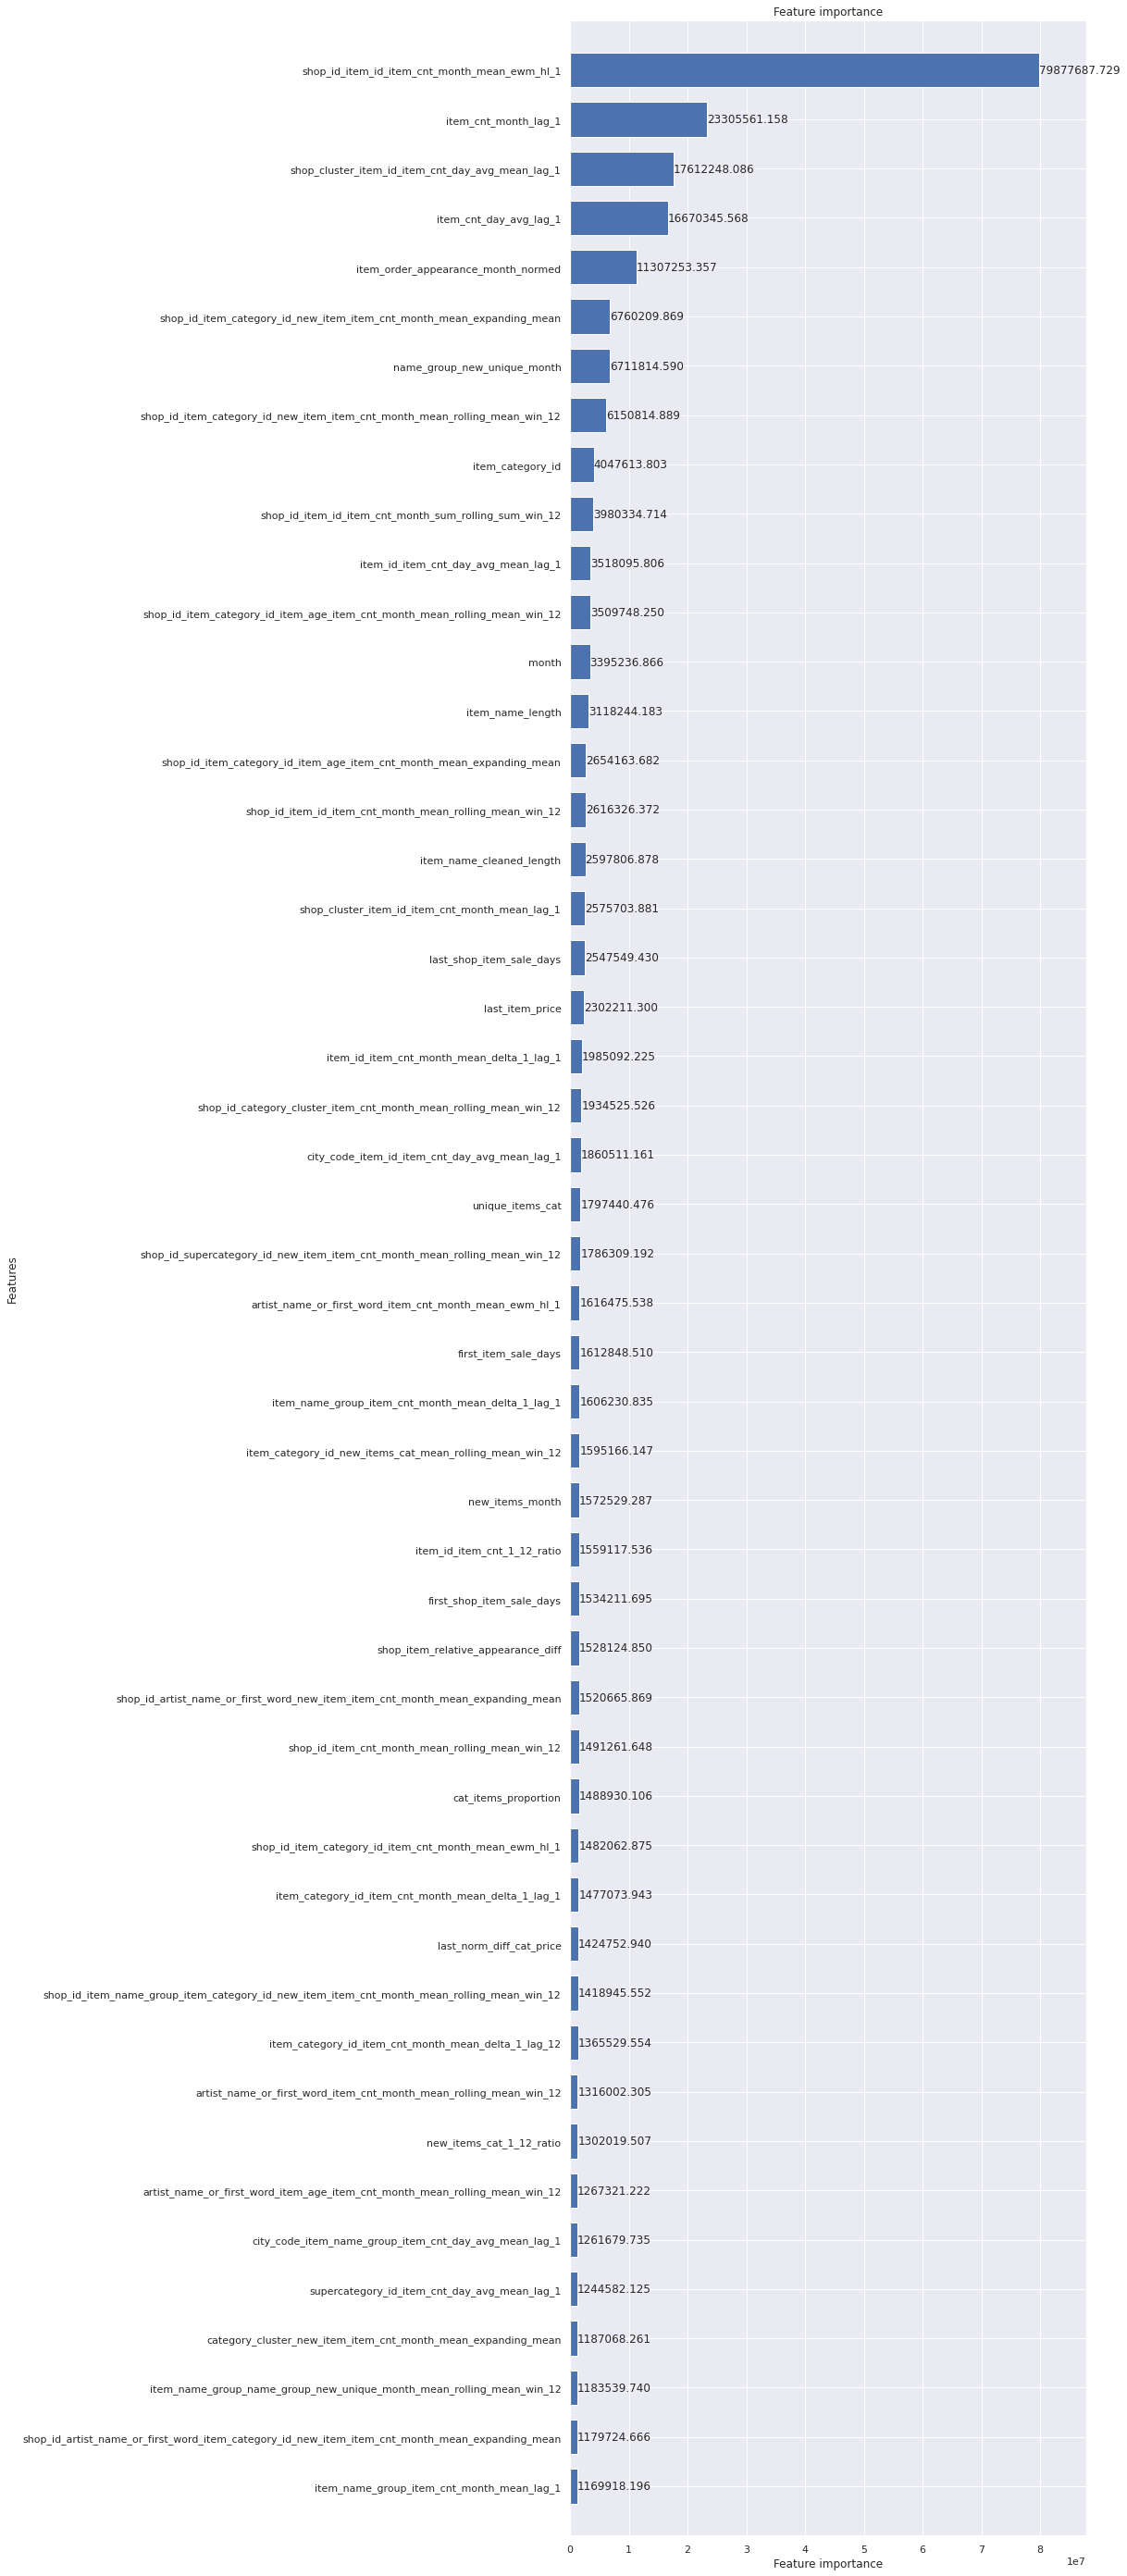

In [56]:
_ = lgbm.plot_importance(booster, figsize=(10,50), height=0.7, importance_type="gain", max_num_features=50)

# Create the test submission  
Split the test items from the data matrix and use the trained model to predict the target.

In [57]:
matrix = pd.read_pickle("checkpoint_final.pkl")
matrix['item_cnt_month'] = matrix['item_cnt_month'].clip(0,20)
keep_from_month = 2
test_month = 34
test = matrix.loc[matrix.date_block_num==test_month, :]
X_test = test.drop(columns="item_cnt_month")
y_test = test.item_cnt_month
del(matrix)

In [58]:
X_test["item_cnt_month"] = booster.predict(X_test.drop(columns=dropcols)).clip(0, 20)
# Merge the predictions with the provided template
test_orig = pd.read_csv("../input/competitive-data-science-predict-future-sales/test.csv")
test = test_orig.merge(
    X_test[["shop_id", "item_id", "item_cnt_month"]],
    on=["shop_id", "item_id"],
    how="inner",
    copy=True,
)
# Verify that the indices of the submission match the original
assert test_orig.equals(test[["ID", "shop_id", "item_id"]])
test[["ID", "item_cnt_month"]].to_csv("submission.csv", index=False)

In [59]:
from os import remove
remove("checkpoint_final.pkl")
remove("matrixcheckpoint.pkl")
print("Finished everything!")

Finished everything!
